# **Final XGBoost work**

## 1) Loading Data and Packages + Util

In [25]:
import os
from google.colab import files
import shutil

import math
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedGroupKFold, cross_val_score, RandomizedSearchCV, GridSearchCV, TunedThresholdClassifierCV, cross_validate
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix, roc_curve, ConfusionMatrixDisplay, precision_recall_curve, average_precision_score, make_scorer, f1_score, precision_score, recall_score
from sklearn.metrics import get_scorer_names, balanced_accuracy_score
import matplotlib.pyplot as plt
from typing_extensions import final
import seaborn as sns
import random

Load data from local folder

In [4]:
os.makedirs('/content/data', exist_ok=True)
destination_folder = '/content/data'
uploaded = files.upload()
for filename in uploaded.keys():
    shutil.move(filename, os.path.join(destination_folder, filename))

Saving adh.csv to adh.csv
Saving all_fitbit_data_daily_w_visit.csv to all_fitbit_data_daily_w_visit.csv
Saving data_daily_w_visits.csv to data_daily_w_visits.csv


Setup fitbit_data

In [5]:
fitbit_data = pd.read_csv('/content/data/data_daily_w_visits.csv')

In [6]:
all_fitbit_data = pd.read_csv('/content/data/all_fitbit_data_daily_w_visit.csv')

In [7]:
adh_data = pd.read_csv('/content/data/adh.csv')

In [8]:
full_fb_data = pd.read_csv('/content/data/full_fb_data.csv')

In [9]:
# Organizing columns
measure_features = ['calories', 'heart', 'steps']
survey_features = ['diet', 'medication', 'symptoms']
target_col = 'visit_day'
all_features = ['avgWeight_per_day',
       'calories', 'heart', 'steps', 'minutes_asleep', 'minutes_awake', 'temp/skin_nightlyRelative',
       'spo2_avg', 'spo2_min', 'spo2_max', 'hrv_dailyRmssd', 'hrv_deepRmssd',
       'br_breathingRate', 'out_of_range_zone_cal', 'out_of_range_zone_max_hr',
       'out_of_range_zone_min_hr', 'fat_burn_zone_cal', 'fat_burn_zone_max_hr',
       'fat_burn_zone_min_hr', 'cardio_zone_cal', 'cardio_zone_max_hr',
       'cardio_zone_min_hr', 'peak_zone_cal', 'peak_zone_max_hr',
       'peak_zone_min_hr', 'diet_response_0.0', 'diet_response_1.0',
       'diet_response_2.0', 'diet_response_nan', 'medication_response_0.0',
       'medication_response_1.0', 'medication_response_2.0',
       'medication_response_nan', 'symptoms_response_0.0',
       'symptoms_response_1.0', 'symptoms_response_2.0',
       'symptoms_response_nan']
one_h_feaatures = ['diet_response_0.0', 'diet_response_1.0',
       'diet_response_2.0', 'diet_response_nan', 'medication_response_0.0',
       'medication_response_1.0', 'medication_response_2.0',
       'medication_response_nan', 'symptoms_response_0.0',
       'symptoms_response_1.0', 'symptoms_response_2.0',
       'symptoms_response_nan']
adh_info = ['synced_fitbit', 'checked_weight',	'did_survey',	'fb_streak',
            'bt_streak',	'surv_streak', 'above_min_thresh',
            'percent_of_day_worn',	'above_thresh']

In [44]:
full_fb_data = pd.concat([all_fitbit_data, adh_data[adh_info]], axis = 1 )

In [46]:
full_fb_data.to_csv('full_fb_data.csv', index=False)

files.download("full_fb_data.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [10]:
def compute_metrics(y_true, y_prob, thresh: float = 0.5):
    y_pred = (y_prob > thresh).astype(int)
    auroc = roc_auc_score(y_true, y_prob)
    auprc = average_precision_score(y_true, y_prob)
    acc = accuracy_score(y_true,y_pred)
    cm = confusion_matrix(y_true,y_pred)

    return acc, auroc, auprc, cm

## 2) Transforming Data

Preliminary setup

In [11]:
# Ensure date is datetime and sort
fitbit_data['date'] = pd.to_datetime(fitbit_data['date'])
fitbit_data = fitbit_data.sort_values(by=['fitbit_user_id', 'date'])
all_fitbit_data['date'] = pd.to_datetime(all_fitbit_data['date'])
all_fitbit_data = all_fitbit_data.sort_values(by=['fitbit_user_id', 'date'])
full_fb_data['date'] = pd.to_datetime(full_fb_data['date'])
full_fb_data = full_fb_data.sort_values(by=['fitbit_user_id', 'date'])

# Shift survey columns
for col in survey_features:
  fitbit_data[col] = fitbit_data.groupby('fitbit_user_id')[col].shift(-1)
  all_fitbit_data[col] = all_fitbit_data.groupby('fitbit_user_id')[col].shift(-1)
  full_fb_data[col] = full_fb_data.groupby('fitbit_user_id')[col].shift(-1)

# Set remaining nan visit columns to 0
fitbit_data[target_col] = fitbit_data[target_col].fillna(0)
all_fitbit_data[target_col] = all_fitbit_data[target_col].fillna(0)
full_fb_data[target_col] = full_fb_data[target_col].fillna(0)

One hot encode

In [ ]:
# One hot encode
fitbit_data = pd.get_dummies(
    fitbit_data,
    columns=survey_features,
    prefix=[col + '_response' for col in survey_features],
    dummy_na=True,
    dtype=float
)

all_fitbit_data = pd.get_dummies(
    all_fitbit_data,
    columns=survey_features,
    prefix=[col + '_response' for col in survey_features],
    dummy_na=True,
    dtype=float
)

In [ ]:
(all_fitbit_data.isna().sum() / len(all_fitbit_data)).sort_values(ascending=False)

In [ ]:
fitbit_data

,Unnamed: 0,date,study_group,fitbit_user_id,avgWeight_per_day,calories,heart,steps,minutes_asleep,minutes_awake,...,diet_response_2.0,diet_response_nan,medication_response_0.0,medication_response_1.0,medication_response_2.0,medication_response_nan,symptoms_response_0.0,symptoms_response_1.0,symptoms_response_2.0,symptoms_response_nan
0,0,2021-07-27,App Money,1,228.619094,2879.0,66.0,6260.0,NaN,NaN,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1,1,2021-07-28,App Money,1,227.560876,3207.0,66.0,10805.0,270.0,46.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
2,2,2021-07-29,App Money,1,227.186091,2911.0,67.0,8292.0,141.0,23.0,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
3,3,2021-07-30,App Money,1,225.973550,3301.0,66.0,8250.0,172.0,53.0,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
4,4,2021-07-31,App Money,1,225.459139,3106.0,66.0,7704.0,99.0,5.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44815,44815,2025-03-12,No App,307,NaN,2244.0,64.0,3297.0,NaN,NaN,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
44816,44816,2025-03-13,No App,307,NaN,2152.0,63.0,3730.0,NaN,NaN,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
44817,44817,2025-03-14,No App,307,NaN,2529.0,64.0,6657.0,NaN,NaN,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
44818,44818,2025-03-15,No App,307,NaN,2494.0,64.0,7626.0,NaN,NaN,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


In [ ]:
fitbit_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44820 entries, 0 to 44819
Data columns (total 26 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   Unnamed: 0               44820 non-null  int64         
 1   date                     44820 non-null  datetime64[ns]
 2   study_group              44820 non-null  object        
 3   fitbit_user_id           44820 non-null  int64         
 4   avgWeight_per_day        32886 non-null  float64       
 5   calories                 41396 non-null  float64       
 6   heart                    34401 non-null  float64       
 7   steps                    41358 non-null  float64       
 8   minutes_asleep           30702 non-null  float64       
 9   minutes_awake            30702 non-null  float64       
 10  days                     44820 non-null  int64         
 11  admit_type               73 non-null     object        
 12  death                    80 non-

In [ ]:
fitbit_data.describe()

,Unnamed: 0,date,fitbit_user_id,avgWeight_per_day,calories,heart,steps,minutes_asleep,minutes_awake,days,...,diet_response_2.0,diet_response_nan,medication_response_0.0,medication_response_1.0,medication_response_2.0,medication_response_nan,symptoms_response_0.0,symptoms_response_1.0,symptoms_response_2.0,symptoms_response_nan
count,44820.000000,44820,44820.000000,32886.000000,41396.000000,34401.000000,41358.000000,30702.000000,30702.000000,44820.000000,...,44820.000000,44820.000000,44820.000000,44820.000000,44820.000000,44820.000000,44820.000000,44820.000000,44820.000000,44820.000000
mean,22409.500000,2023-03-04 14:47:42.650602240,152.518072,189.784778,2235.929534,65.401733,5234.779148,383.079734,54.538662,89.500000,...,0.360018,0.471307,0.004462,0.019835,0.504507,0.471196,0.357854,0.156917,0.014123,0.471107
min,0.000000,2021-07-26 00:00:00,1.000000,33.951148,267.000000,36.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,11204.750000,2022-05-26 00:00:00,80.000000,160.275874,1786.000000,60.000000,2201.000000,317.250000,36.000000,44.750000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,22409.500000,2023-02-16 00:00:00,152.000000,183.644846,2151.500000,64.000000,4441.000000,391.000000,53.000000,89.500000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,33614.250000,2023-11-08 00:00:00,222.000000,211.643520,2557.000000,72.000000,7291.000000,457.000000,70.000000,134.250000,...,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000
max,44819.000000,2025-03-16 00:00:00,307.000000,398.705527,13442.000000,118.000000,37020.000000,1545.000000,435.000000,179.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
std,12938.563869,NaN,86.485919,45.383202,767.532572,9.289836,4163.937032,126.255121,29.144155,51.961302,...,0.480011,0.499182,0.066652,0.139434,0.499985,0.499175,0.479374,0.363726,0.118000,0.499170


In [ ]:
fitbit_data[target_col]

,visit_day
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0
...,...
44815,0.0
44816,0.0
44817,0.0
44818,0.0


In [ ]:
fitbit_data[measure_features + one_h_feaatures + [target_col]].corr()

,avgWeight_per_day,calories,heart,steps,diet_response_0.0,diet_response_1.0,diet_response_2.0,diet_response_nan,medication_response_0.0,medication_response_1.0,medication_response_2.0,medication_response_nan,symptoms_response_0.0,symptoms_response_1.0,symptoms_response_2.0,symptoms_response_nan,visit_day
avgWeight_per_day,1.000000,0.373354,0.129531,-0.144976,-0.012775,0.115264,0.037072,-0.116215,0.026173,0.037068,0.100517,-0.116188,0.037277,0.057270,0.128357,-0.115703,-0.000209
calories,0.373354,1.000000,-0.023124,0.456305,-0.022520,0.036252,-0.007507,-0.009382,-0.001204,0.008699,0.006654,-0.009054,0.047490,-0.054580,0.015333,-0.009188,-0.015476
heart,0.129531,-0.023124,1.000000,-0.173048,-0.033483,0.015795,0.039888,-0.037826,0.033239,0.069086,0.012165,-0.038015,-0.024675,0.060177,0.062618,-0.037960,0.014878
steps,-0.144976,0.456305,-0.173048,1.000000,-0.014462,0.004755,0.038059,-0.035000,-0.014207,-0.012302,0.040083,-0.034741,0.138243,-0.112696,-0.063136,-0.035018,-0.030752
diet_response_0.0,-0.012775,-0.022520,-0.033483,-0.014462,1.000000,-0.075231,-0.143982,-0.181251,0.055853,0.091097,0.148067,-0.181211,0.072133,0.143803,0.028087,-0.180695,-0.002408
diet_response_1.0,0.115264,0.036252,0.015795,0.004755,-0.075231,1.000000,-0.293930,-0.370012,0.027959,0.118060,0.331891,-0.369140,0.259858,0.162634,0.005971,-0.369469,-0.005680
diet_response_2.0,0.037072,-0.007507,0.039888,0.038059,-0.143982,-0.293930,1.000000,-0.708156,0.024406,0.020650,0.697280,-0.707438,0.519989,0.252394,0.102067,-0.707405,-0.015198
diet_response_nan,-0.116215,-0.009382,-0.037826,-0.035000,-0.181251,-0.370012,-0.708156,1.000000,-0.063212,-0.133992,-0.951290,0.998702,-0.703621,-0.406719,-0.112628,0.998702,0.019373
medication_response_0.0,0.026173,-0.001204,0.033239,-0.014207,0.055853,0.027959,0.024406,-0.063212,1.000000,-0.009524,-0.067556,-0.063198,0.010076,0.053948,0.060072,-0.063187,0.005099
medication_response_1.0,0.037068,0.008699,0.069086,-0.012302,0.091097,0.118060,0.020650,-0.133992,-0.009524,1.000000,-0.143542,-0.134282,0.040013,0.120324,0.034505,-0.134258,0.001566


## 3a) Analyzing Data (with NaN)

Missingness in columns

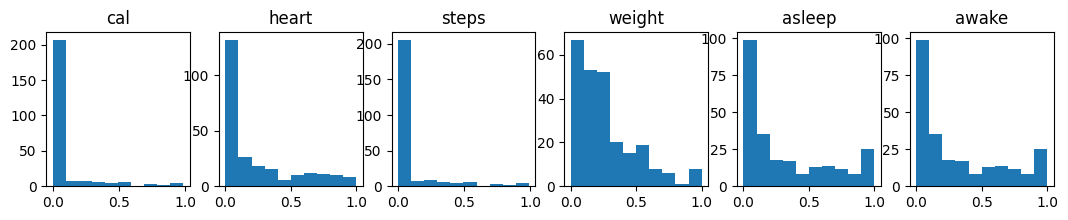

In [ ]:
cal = []
heart = []
steps = []
weight = []
asleep = []
awake = []
for i in all_fitbit_data['fitbit_user_id'].unique():
    temp = all_fitbit_data[all_fitbit_data['fitbit_user_id']==i].reset_index(drop=True)
    cal += [temp['calories'].isna().sum()/len(temp)]
    heart += [temp['heart'].isna().sum()/len(temp)]
    steps += [temp['steps'].isna().sum()/len(temp)]
    weight += [temp['avgWeight_per_day'].isna().sum()/len(temp)]
    asleep += [temp['minutes_asleep'].isna().sum()/len(temp)]
    awake += [temp['minutes_awake'].isna().sum()/len(temp)]

fig, axs = plt.subplots(1,6,figsize=(13,2))
axs[0].hist(cal)
axs[0].set_title('cal')
axs[1].hist(heart)
axs[1].set_title('heart')
axs[2].hist(steps)
axs[2].set_title('steps')
axs[3].hist(weight)
axs[3].set_title('weight')
axs[4].hist(asleep)
axs[4].set_title('asleep')
axs[5].hist(awake)
axs[5].set_title('awake')
plt.show()

*   weight, sleep numbers are missing alot

In [ ]:
fitbit_data_w_visits = fitbit_data[fitbit_data['visit_day'] == 1].reset_index(drop=True)
fitbit_data_w_visits

,Unnamed: 0,date,study_group,fitbit_user_id,avgWeight_per_day,calories,heart,steps,diet,medication,symptoms,minutes_asleep,minutes_awake,days,admit_type,death,visit_day
0,921,2021-08-31,App Money,7,NaN,2305.0,102.0,2609.0,NaN,NaN,NaN,462.0,46.0,21,ED,0.0,1.0
1,950,2021-09-29,App Money,7,NaN,1898.0,NaN,915.0,NaN,NaN,NaN,NaN,NaN,50,ED to admit,0.0,1.0
2,959,2021-10-08,App Money,7,NaN,1736.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,59,ED to admit,0.0,1.0
3,991,2021-11-09,App Money,7,NaN,1736.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,91,admission,0.0,1.0
4,1020,2021-12-08,App Money,7,NaN,2379.0,96.0,2210.0,NaN,NaN,NaN,NaN,NaN,120,ED,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,40015,2024-05-26,No App,272,NaN,1055.0,NaN,802.0,NaN,NaN,NaN,NaN,NaN,55,ED to admit,0.0,1.0
76,40024,2024-06-04,No App,272,NaN,1832.0,88.0,14633.0,NaN,NaN,NaN,NaN,NaN,64,ED,0.0,1.0
77,41361,2024-09-19,App Money,279,161.819108,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,141,admission,0.0,1.0
78,41632,2024-07-07,App Money,284,241.626352,2584.0,76.0,2694.0,1.0,2.0,0.0,122.0,17.0,52,admission,0.0,1.0


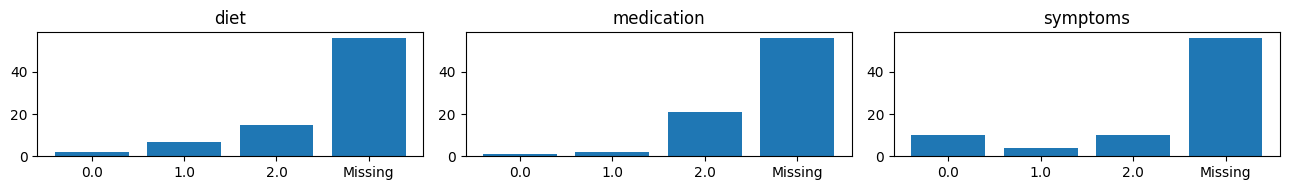

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(13, 2))

for ax, col in zip(axs, ['diet', 'medication', 'symptoms']):
    # Replace NaNs with a placeholder
    values = fitbit_data_w_visits[col].fillna('Missing').astype(str)

    # Get value counts
    counts = values.value_counts().sort_index()

    # Bar plot
    ax.bar(counts.index, counts.values)
    ax.set_title(col)

plt.tight_layout()
plt.show()

In [ ]:
pre_visit_data = []

for user_id, group in fitbit_data.groupby('fitbit_user_id'):
    group = group.sort_values('days').reset_index(drop=True)

    visit_indices = group.index[group['visit_day'] == 1].tolist()

    for vi in visit_indices:
        start = max(vi - 21, 0)
        end = vi + 1  # include the visit day
        temp = group.iloc[start:end].copy()
        temp['days_to_visit'] = temp['days'] - temp['days'].iloc[-1]
        temp['fitbit_user_id'] = user_id
        pre_visit_data.append(temp)

# Combine all extracted windows
pre_visit_df = pd.concat(pre_visit_data, ignore_index=True)

In [ ]:
pre_visit_df

,Unnamed: 0,date,study_group,fitbit_user_id,avgWeight_per_day,calories,heart,steps,diet,medication,symptoms,minutes_asleep,minutes_awake,days,admit_type,death,visit_day,days_to_visit
0,907,2021-08-17,App Money,7,189.928013,2413.0,95.0,3583.0,NaN,NaN,NaN,177.0,3.0,7,NaN,NaN,0.0,-14
1,908,2021-08-18,App Money,7,NaN,2252.0,94.0,2567.0,NaN,NaN,NaN,303.0,35.0,8,NaN,NaN,0.0,-13
2,909,2021-08-19,App Money,7,NaN,2261.0,94.0,2440.0,1.0,1.0,1.0,127.0,9.0,9,NaN,NaN,0.0,-12
3,910,2021-08-20,App Money,7,200.693907,2307.0,94.0,2583.0,NaN,NaN,NaN,135.0,10.0,10,NaN,NaN,0.0,-11
4,911,2021-08-21,App Money,7,NaN,1869.0,NaN,489.0,NaN,NaN,NaN,82.0,7.0,11,NaN,NaN,0.0,-10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1172,41744,2024-10-27,App Money,284,244.712820,2315.0,66.0,2312.0,1.0,2.0,0.0,76.0,8.0,164,NaN,NaN,0.0,-4
1173,41745,2024-10-28,App Money,284,247.578826,2255.0,67.0,1854.0,1.0,2.0,0.0,187.0,51.0,165,NaN,NaN,0.0,-3
1174,41746,2024-10-29,App Money,284,243.830972,2347.0,66.0,3762.0,1.0,2.0,0.0,286.0,45.0,166,NaN,NaN,0.0,-2
1175,41747,2024-10-30,App Money,284,243.279817,2208.0,65.0,2805.0,1.0,2.0,0.0,319.0,53.0,167,NaN,NaN,0.0,-1


In [ ]:
from google.colab import sheets
sheet = sheets.InteractiveSheet(df=pre_visit_df)

https://docs.google.com/spreadsheets/d/1GzUlOQ4BdT0SrH0jiN7jxvlnG7v_Oayf9xwOkA_3TwU/edit#gid=0


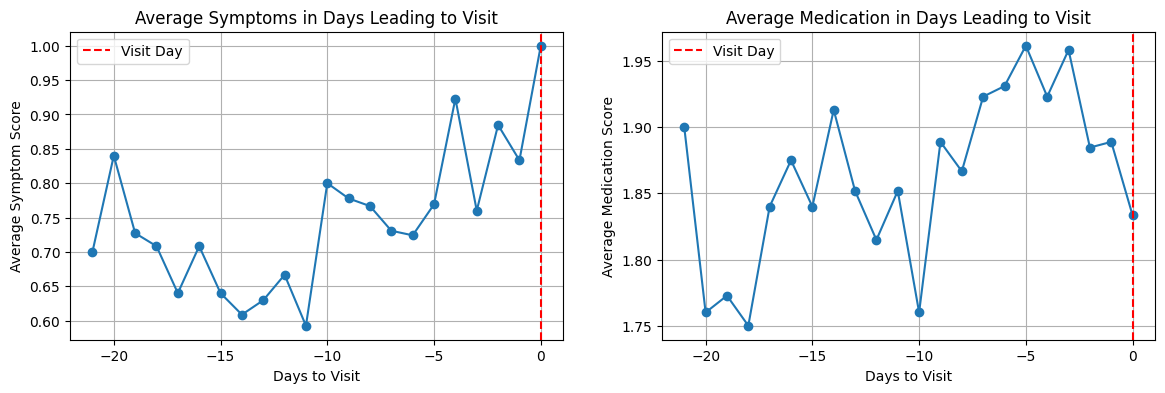

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(14, 4), sharey = False)

avg_symptoms = pre_visit_df.groupby('days_to_visit')['symptoms'].mean()
axs[0].plot(avg_symptoms.index, avg_symptoms.values, marker='o')
axs[0].set_title("Average Symptoms in Days Leading to Visit")
axs[0].set_xlabel("Days to Visit")
axs[0].set_ylabel("Average Symptom Score")
axs[0].grid(True)
axs[0].axvline(0, color='red', linestyle='--', label='Visit Day')
axs[0].legend()

avg_medication = pre_visit_df.groupby('days_to_visit')['medication'].mean()
axs[1].plot(avg_medication.index, avg_medication.values, marker='o')
axs[1].set_title("Average Medication in Days Leading to Visit")
axs[1].set_xlabel("Days to Visit")
axs[1].set_ylabel("Average Medication Score")
axs[1].grid(True)
axs[1].axvline(0, color='red', linestyle='--', label='Visit Day')
axs[1].legend()

plt.show()

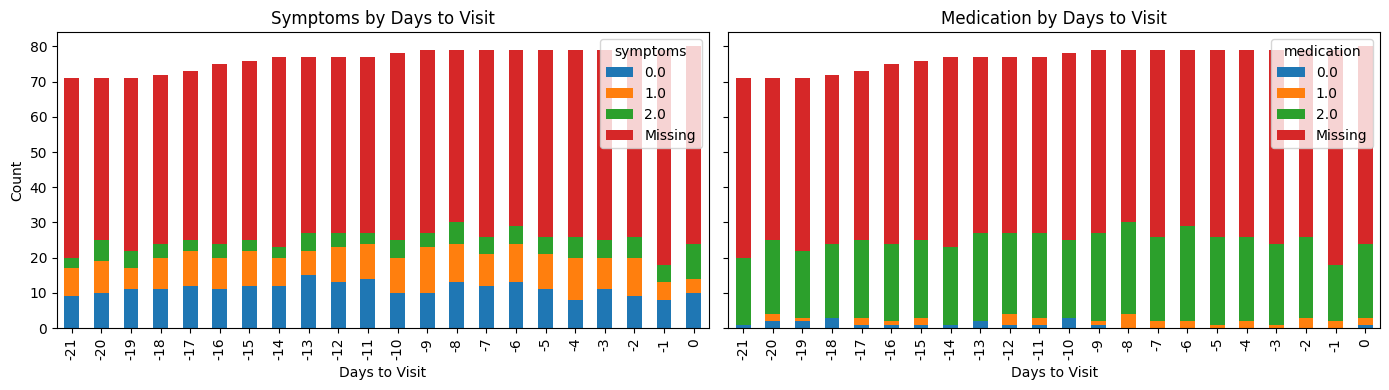

In [ ]:
# Replace NaNs with a string label
pre_visit_df['symptoms'] = pre_visit_df['symptoms'].fillna('Missing').astype(str)
pre_visit_df['medication'] = pre_visit_df['medication'].fillna('Missing').astype(str)

# Group and unstack to prepare for stacked bar plotting
symptoms_ct = pre_visit_df.groupby(['days_to_visit', 'symptoms']).size().unstack(fill_value=0)
medication_ct = pre_visit_df.groupby(['days_to_visit', 'medication']).size().unstack(fill_value=0)

# Plot stacked bars
fig, axs = plt.subplots(1, 2, figsize=(14, 4), sharey=True)

# Symptoms
symptoms_ct.plot(kind='bar', stacked=True, ax=axs[0])
axs[0].set_title("Symptoms by Days to Visit")
axs[0].set_xlabel("Days to Visit")
axs[0].set_ylabel("Count")

# Medication
medication_ct.plot(kind='bar', stacked=True, ax=axs[1])
axs[1].set_title("Medication by Days to Visit")
axs[1].set_xlabel("Days to Visit")

plt.tight_layout()
plt.show()


## 3b) Analyzing Data (sync and no Nan)

In [57]:
full_fb_data.describe()

,Unnamed: 0,date,fitbit_user_id,avgWeight_per_day,calories,heart,steps,diet,medication,symptoms,...,peak_zone_min_hr,synced_fitbit,checked_weight,did_survey,fb_streak,bt_streak,surv_streak,above_min_thresh,percent_of_day_worn,above_thresh
count,44820.000000,44820,44820.000000,32886.000000,41396.000000,34401.000000,41358.000000,23696.000000,23701.000000,23705.000000,...,38150.000000,44820.000000,44820.000000,32096.000000,32096.000000,32096.000000,32096.000000,36005.000000,44820.000000,44820.000000
mean,22409.500000,2023-03-04 14:47:42.650602240,152.518072,189.784778,2235.929534,65.401733,5234.779148,1.613732,1.945614,0.350095,...,140.311429,0.803458,0.771218,0.740373,43.029381,24.322969,19.140547,0.750729,0.681580,0.794378
min,0.000000,2021-07-26 00:00:00,1.000000,33.951148,267.000000,36.000000,0.000000,0.000000,0.000000,0.000000,...,91.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,11204.750000,2022-05-26 00:00:00,80.000000,160.275874,1786.000000,60.000000,2201.000000,1.000000,2.000000,0.000000,...,134.000000,1.000000,1.000000,0.000000,3.000000,1.000000,0.000000,1.000000,0.385417,1.000000
50%,22409.500000,2023-02-16 00:00:00,152.000000,183.644846,2151.500000,64.000000,4441.000000,2.000000,2.000000,0.000000,...,140.000000,1.000000,1.000000,1.000000,22.000000,9.000000,4.000000,1.000000,0.926389,1.000000
75%,33614.250000,2023-11-08 00:00:00,222.000000,211.643520,2557.000000,72.000000,7291.000000,2.000000,2.000000,1.000000,...,148.000000,1.000000,1.000000,1.000000,71.000000,32.000000,22.000000,1.000000,0.986111,1.000000
max,44819.000000,2025-03-16 00:00:00,307.000000,398.705527,13442.000000,118.000000,37020.000000,2.000000,2.000000,2.000000,...,166.000000,1.000000,1.000000,1.000000,181.000000,181.000000,180.000000,1.000000,2.000000,1.000000
std,12938.563869,NaN,86.485919,45.383202,767.532572,9.289836,4163.937032,0.609536,0.261358,0.530044,...,8.776043,0.397387,0.420053,0.438437,48.811625,34.726318,32.478820,0.432597,0.402873,0.404160


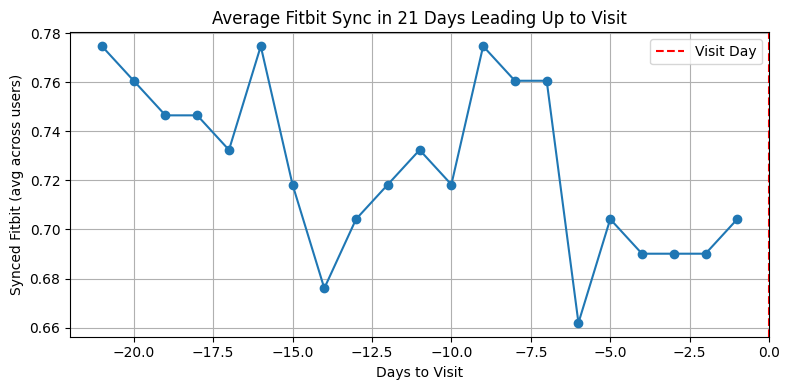

In [60]:
# Looking at fitbit sync (every visit)
# Collect sync data relative to visit day
sync_data = []

for user_id, group in full_fb_data.groupby('fitbit_user_id'):
    group = group.reset_index(drop=True)

    # Find all visit indices
    visit_indices = group.index[group['visit_day'] == 1].tolist()

    for visit_idx in visit_indices:
        # Ensure there's at least 14 days before the visit
        if visit_idx >= 14:
            pre_visit_window = group.iloc[visit_idx - 21: visit_idx].copy()
            pre_visit_window = pre_visit_window.reset_index(drop=True)
            pre_visit_window['days_to_visit'] = range(-21, 0)
            sync_data.append(pre_visit_window[['days_to_visit', 'synced_fitbit']])

# Combine all user windows
sync_df = pd.concat(sync_data, ignore_index=True)

# Average synced_fitbit by relative day
sync_summary = sync_df.groupby('days_to_visit')['synced_fitbit'].mean()

# Plotting
plt.figure(figsize=(8, 4))
plt.plot(sync_summary.index, sync_summary.values, marker='o')
plt.axvline(x=0, color='red', linestyle='--', label='Visit Day')
plt.title('Average Fitbit Sync in 21 Days Leading Up to Visit')
plt.xlabel('Days to Visit')
plt.ylabel('Synced Fitbit (avg across users)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [13]:
pre_visit_data = []

for user_id, group in full_fb_data.groupby('fitbit_user_id'):
    group = group.sort_values('days').reset_index(drop=True)

    # Get index of the first visit only
    visit_indices = group.index[group['visit_day'] == 1].tolist()
    if not visit_indices:
        continue  # Skip users with no visits

    vi = visit_indices[0]  # Only the first visit
    start = max(vi - 14, 0)
    end = vi + 1  # include the visit day
    temp = group.iloc[start:end].copy()
    temp['days_to_visit'] = temp['days'] - temp['days'].iloc[-1]
    temp['fitbit_user_id'] = user_id
    pre_visit_data.append(temp)

# Combine all extracted windows
pre_visit_df = pd.concat(pre_visit_data, ignore_index=True)


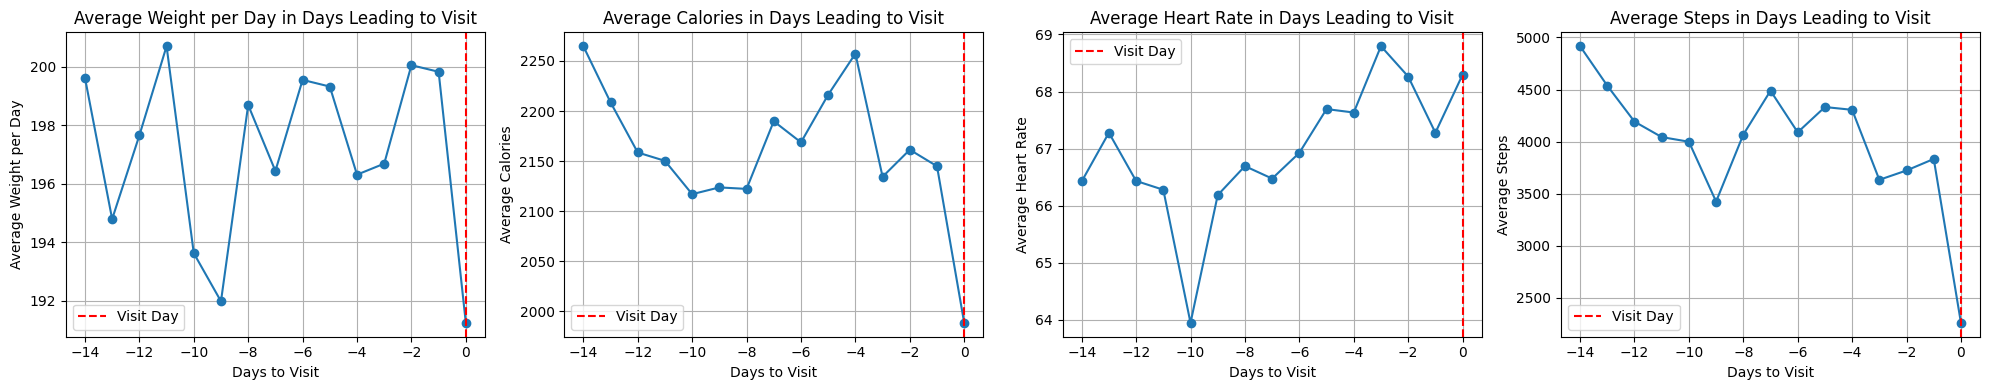

In [14]:
fig, axs = plt.subplots(1, 4, figsize=(20, 4), sharey = False)

features = ['avgWeight_per_day', 'calories', 'heart', 'steps']
titles = ['Average Weight per Day', 'Average Calories', 'Average Heart Rate', 'Average Steps']

for i, feature in enumerate(features):
    avg_vals = pre_visit_df.groupby('days_to_visit')[feature].mean()
    axs[i].plot(avg_vals.index, avg_vals.values, marker='o')
    axs[i].set_title(f"{titles[i]} in Days Leading to Visit")
    axs[i].set_xlabel("Days to Visit")
    axs[i].set_ylabel(titles[i])
    axs[i].grid(True)
    axs[i].axvline(0, color='red', linestyle='--', label='Visit Day')
    axs[i].legend()

plt.tight_layout()
plt.show()


In [15]:
pre_visit_data

[    Unnamed: 0       date study_group  fitbit_user_id  avgWeight_per_day  \
 7          907 2021-08-17   App Money               7         189.928013   
 8          908 2021-08-18   App Money               7                NaN   
 9          909 2021-08-19   App Money               7                NaN   
 10         910 2021-08-20   App Money               7         200.693907   
 11         911 2021-08-21   App Money               7                NaN   
 12         912 2021-08-22   App Money               7                NaN   
 13         913 2021-08-23   App Money               7         209.659362   
 14         914 2021-08-24   App Money               7                NaN   
 15         915 2021-08-25   App Money               7                NaN   
 16         916 2021-08-26   App Money               7                NaN   
 17         917 2021-08-27   App Money               7                NaN   
 18         918 2021-08-28   App Money               7                NaN   

In [22]:
pre_visit_data = []

for user_id, group in full_fb_data.groupby('fitbit_user_id'):
    group = group.sort_values('days').reset_index(drop=True)

    # Get index of the first visit only
    visit_indices = group.index[group['visit_day'] == 1].tolist()
    if not visit_indices:
        continue  # Skip users with no visits

    if group.iloc[0]['study_group'] == 'No App':
      continue # Skip users with no survey results

    vi = visit_indices[0]  # Only the first visit
    start = max(vi - 21, 0)
    end = vi + 1  # include the visit day
    temp = group.iloc[start:end].copy()
    temp['days_to_visit'] = temp['days'] - temp['days'].iloc[-1]
    temp['fitbit_user_id'] = user_id
    pre_visit_data.append(temp)

# Combine all extracted windows
pre_visit_df = pd.concat(pre_visit_data, ignore_index=True)

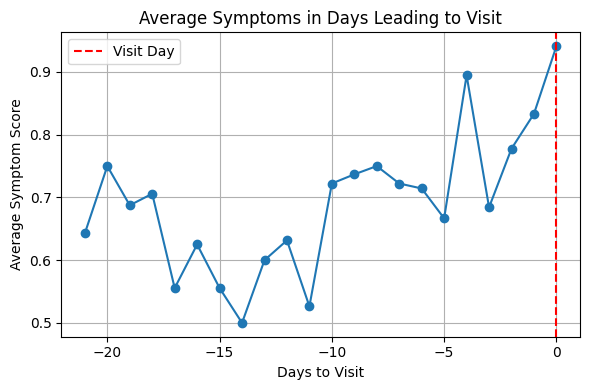

In [23]:
# Create figure and axis
fig, ax = plt.subplots(figsize=(6, 4))

# Compute average symptom score per day-to-visit
avg_symptoms = pre_visit_df.groupby('days_to_visit')['symptoms'].mean()

# Plot
ax.plot(avg_symptoms.index, avg_symptoms.values, marker='o')
ax.set_title("Average Symptoms in Days Leading to Visit")
ax.set_xlabel("Days to Visit")
ax.set_ylabel("Average Symptom Score")
ax.grid(True)
ax.axvline(0, color='red', linestyle='--', label='Visit Day')
ax.legend()

plt.tight_layout()
plt.show()

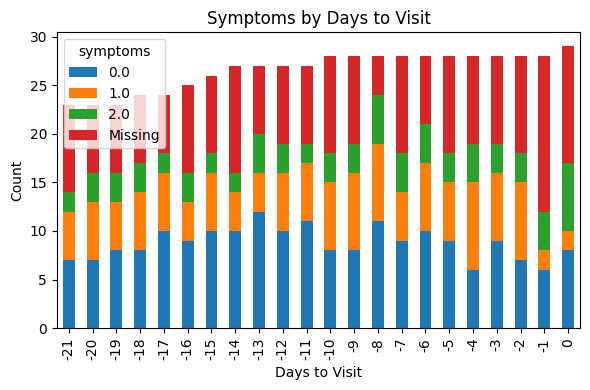

In [24]:
# Replace NaNs with a string label
pre_visit_df['symptoms'] = pre_visit_df['symptoms'].fillna('Missing').astype(str)

# Group and unstack to prepare for stacked bar plotting
symptoms_ct = pre_visit_df.groupby(['days_to_visit', 'symptoms']).size().unstack(fill_value=0)

# Plot stacked bars
fig, axs = plt.subplots(figsize=(6, 4))

# Symptoms
symptoms_ct.plot(kind='bar', stacked=True, ax=axs)
axs.set_title("Symptoms by Days to Visit")
axs.set_xlabel("Days to Visit")
axs.set_ylabel("Count")

plt.tight_layout()
plt.show()

In [45]:
random_week_df = []
window_size = 22  # 2 weeks + 1 day

# Set of columns to check for missingness
check_columns = ['avgWeight_per_day', 'calories', 'heart', 'steps']

for user_id, group in full_fb_data.groupby('fitbit_user_id'):
    group = group.sort_values('days').reset_index(drop=True)

    # Skip users with 'No App' in study_group
    if group.iloc[0]['study_group'] == 'No App':
        continue

    best_windows = []

    # Slide window over the user’s data
    for i in range(len(group) - window_size + 1):
        window = group.iloc[i:i+window_size].copy()
        total_vals = window[check_columns].size
        non_missing_vals = window[check_columns].count().sum()
        missing_ratio = 1 - (non_missing_vals / total_vals)

        # Only accept windows with <30% missing data
        if missing_ratio < 0.3:
            best_windows.append((i, missing_ratio))

    if best_windows:
        # Randomly choose one of the valid windows (you can change this to min missing if preferred)
        chosen_start, _ = random.choice(best_windows)
        chosen_window = group.iloc[chosen_start:chosen_start+window_size].copy()
        chosen_window['days_to_visit'] = range(-21, 1)  # match the same scale
        chosen_window['fitbit_user_id'] = user_id
        random_week_df.append(chosen_window)

# Combine
random_week_df = pd.concat(random_week_df, ignore_index=True)

/tmp/ipython-input-43-382134261.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[i].legend()


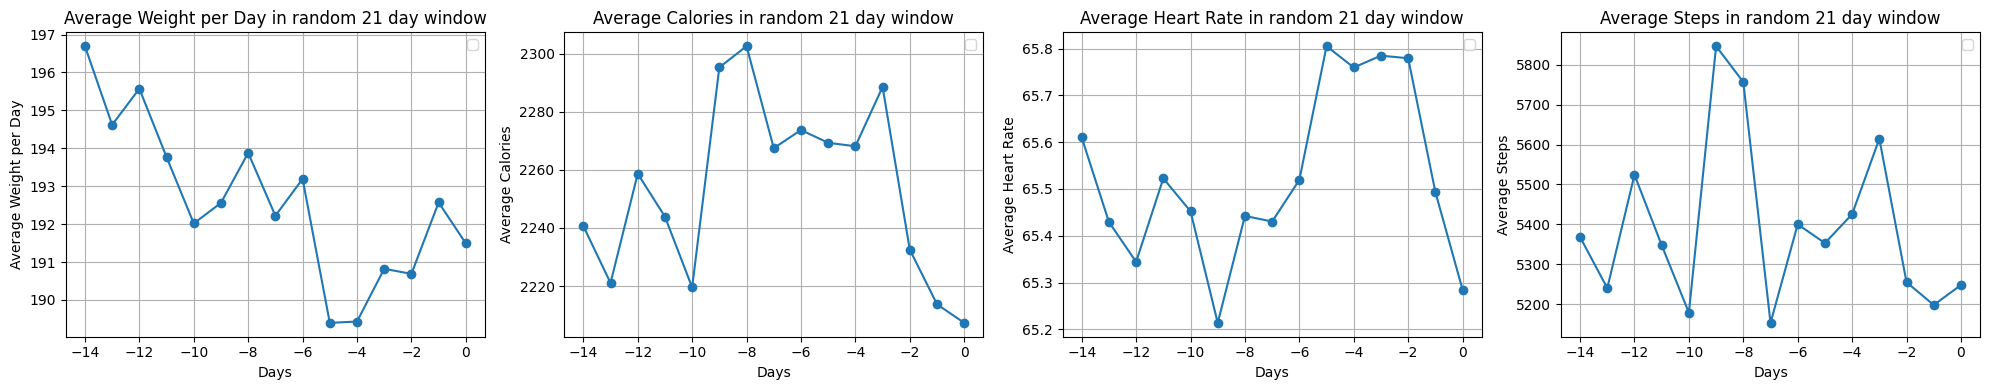

In [43]:
fig, axs = plt.subplots(1, 4, figsize=(20, 4), sharey = False)

features = ['avgWeight_per_day', 'calories', 'heart', 'steps']
titles = ['Average Weight per Day', 'Average Calories', 'Average Heart Rate', 'Average Steps']

for i, feature in enumerate(features):
    avg_vals = random_week_df.groupby('days_to_visit')[feature].mean()
    axs[i].plot(avg_vals.index, avg_vals.values, marker='o')
    axs[i].set_title(f"{titles[i]} in random 21 day window")
    axs[i].set_xlabel("Days")
    axs[i].set_ylabel(titles[i])
    axs[i].grid(True)
    axs[i].legend()

plt.tight_layout()
plt.show()

/tmp/ipython-input-46-2446573048.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


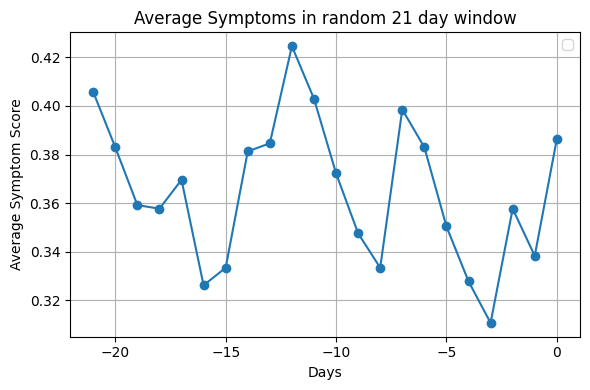

In [46]:
# Create figure and axis
fig, ax = plt.subplots(figsize=(6, 4))

# Compute average symptom score per day-to-visit
avg_symptoms = random_week_df.groupby('days_to_visit')['symptoms'].mean()

# Plot
ax.plot(avg_symptoms.index, avg_symptoms.values, marker='o')
ax.set_title("Average Symptoms in random 21 day window")
ax.set_xlabel("Days")
ax.set_ylabel("Average Symptom Score")
ax.grid(True)
ax.legend()

plt.tight_layout()
plt.show()

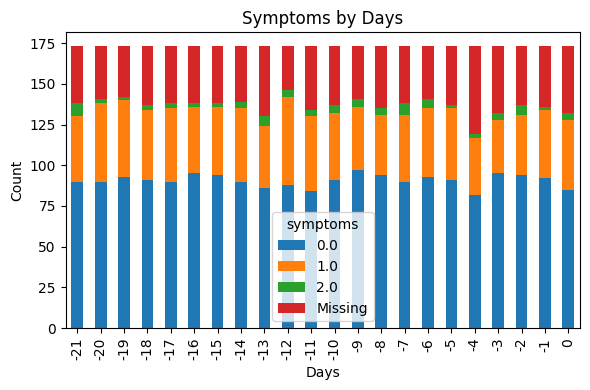

In [47]:
# Replace NaNs with a string label
random_week_df['symptoms'] = random_week_df['symptoms'].fillna('Missing').astype(str)

# Group and unstack to prepare for stacked bar plotting
symptoms_ct = random_week_df.groupby(['days_to_visit', 'symptoms']).size().unstack(fill_value=0)

# Plot stacked bars
fig, axs = plt.subplots(figsize=(6, 4))

# Symptoms
symptoms_ct.plot(kind='bar', stacked=True, ax=axs)
axs.set_title("Symptoms by Days")
axs.set_xlabel("Days")
axs.set_ylabel("Count")

plt.tight_layout()
plt.show()

In [60]:
clean_pre_visit_windows = []
window_size = 22  # 14 days + visit day
check_columns = ['symptoms']

for user_id, group in full_fb_data.groupby('fitbit_user_id'):
    group = group.sort_values('days').reset_index(drop=True)

    # Skip 'No App' users
    if group.iloc[0]['study_group'] == 'No App':
        continue

    # Get index of the first visit only
    visit_indices = group.index[group['visit_day'] == 1].tolist()
    if not visit_indices:
        continue

    vi = visit_indices[0]
    start = vi - window_size + 1
    end = vi + 1  # inclusive of visit day

    # Skip if not enough data before visit
    if start < 0:
        continue

    window = group.iloc[start:end].copy()

    # Check missingness
    total_vals = window[check_columns].size
    non_missing_vals = window[check_columns].count().sum()
    missing_ratio = 1 - (non_missing_vals / total_vals)

    if missing_ratio <= 0.5:
        window['days_to_visit'] = window['days'] - window['days'].iloc[-1]
        window['fitbit_user_id'] = user_id
        clean_pre_visit_windows.append(window)

# Combine into a single DataFrame
clean_pre_visit_df = pd.concat(clean_pre_visit_windows, ignore_index=True)

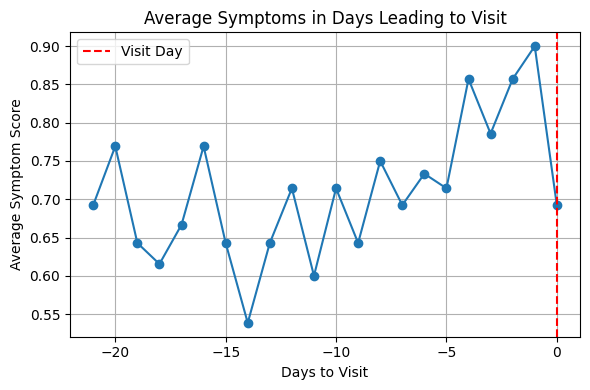

In [61]:
# Create figure and axis
fig, ax = plt.subplots(figsize=(6, 4))

# Compute average symptom score per day-to-visit
avg_symptoms = clean_pre_visit_df.groupby('days_to_visit')['symptoms'].mean()

# Plot
ax.plot(avg_symptoms.index, avg_symptoms.values, marker='o')
ax.set_title("Average Symptoms in Days Leading to Visit")
ax.set_xlabel("Days to Visit")
ax.set_ylabel("Average Symptom Score")
ax.grid(True)
ax.axvline(0, color='red', linestyle='--', label='Visit Day')
ax.legend()

plt.tight_layout()
plt.show()

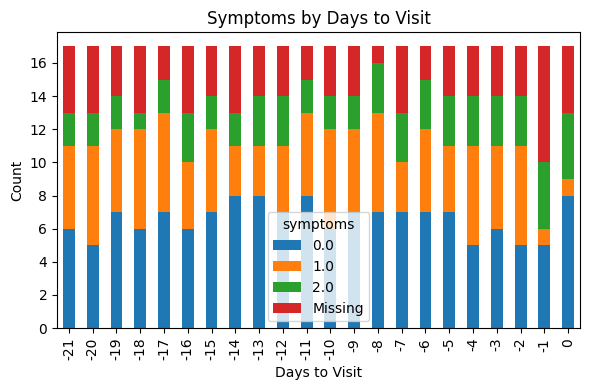

In [62]:
# Replace NaNs with a string label
clean_pre_visit_df['symptoms'] = clean_pre_visit_df['symptoms'].fillna('Missing').astype(str)

# Group and unstack to prepare for stacked bar plotting
symptoms_ct = clean_pre_visit_df.groupby(['days_to_visit', 'symptoms']).size().unstack(fill_value=0)

# Plot stacked bars
fig, axs = plt.subplots(figsize=(6, 4))

# Symptoms
symptoms_ct.plot(kind='bar', stacked=True, ax=axs)
axs.set_title("Symptoms by Days to Visit")
axs.set_xlabel("Days to Visit")
axs.set_ylabel("Count")

plt.tight_layout()
plt.show()

## 4) Setting Visit Col + Imputation + Standardize

In [ ]:
def mark_two_weeks_before_visits(df):
    df = df.copy()

    for user_id, group in df.groupby('fitbit_user_id'):
        visit_days = group.loc[group['visit_day'] == 1, 'days'].values

        for vd in visit_days:
            mask = (df['fitbit_user_id'] == user_id) & (df['days'] >= vd - 14) & (df['days'] <= vd)
            df.loc[mask, 'visit_day'] = 1

    return df

def mark_up_to_final_visit(df):
    df = df.copy()

    for user_id, group in df.groupby('fitbit_user_id'):
        user_mask = df['fitbit_user_id'] == user_id
        visit_days = group.loc[group['visit_day'] == 1, 'days']

        if not visit_days.empty:
            last_visit_day = visit_days.max()
            mask = user_mask & (df['days'] <= last_visit_day)
            df.loc[mask, 'visit_day'] = 1

    return df

In [ ]:
def fix_nans(df, features, max_nans=3, window_days=7):
    df = df.copy()
    cleaned_data = []

    for _, group in df.groupby('fitbit_user_id'):
        group = group.copy().reset_index(drop=True)
        feature_values = {feature: [] for feature in features}

        for i in range(0, len(group), window_days):
            window = group.iloc[i:i+window_days].copy()
            drop_window = False

            for feature in features:
                nan_count = window[feature].isna().sum()
                if nan_count >= max_nans:
                    drop_window = True

                for j in range(len(window)):
                    val = window.iloc[j][feature]
                    if pd.notna(val):
                        feature_values[feature].append(val)
                    else:
                        if len(feature_values[feature]) == 0:
                            drop_window = True
                        else:
                            mean_val = float(np.mean(feature_values[feature]))
                            feature_values[feature].append(mean_val)
                            window.loc[window.index[j], feature] = mean_val

            if not drop_window:
                cleaned_data.append(window)

    result_df = pd.concat(cleaned_data, ignore_index=True)
    return result_df

In [ ]:
week_level = mark_two_weeks_before_visits(fitbit_data)
user_level = mark_up_to_final_visit(fitbit_data)

week_level = fix_nans(week_level, measure_features)
user_level = fix_nans(user_level, measure_features)

scaler = StandardScaler()

week_scaled = week_level.copy()
week_scaled[measure_features] = scaler.fit_transform(week_scaled[measure_features])

user_scaled = user_level.copy()
user_scaled[measure_features] = scaler.fit_transform(user_scaled[measure_features])

In [ ]:
week_scaled.to_csv('week_level.csv', index=False)
user_scaled.to_csv('user_level.csv', index=False)

files.download("week_level.csv")
files.download("user_level.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>